In [ ]:
from dataclasses import asdict

from nerfstudio.cameras.camera_optimizers import CameraOptimizerConfig
from nerfstudio.data.datamanagers.ad_datamanager import ADDataManagerConfig
from nerfstudio.data.dataparsers.pandaset_dataparser import PandaSetDataParserConfig
from nerfstudio.generative.diffusion_model import DiffusionModelConfig, DiffusionModelId, DiffusionModelType
from nerfstudio.models.neurad import NeuRADModel, NeuRADModelConfig
from nerfstudio.pipelines.diffusion_nerf_pipeline import DiffusionNerfConfig

sequence = "001"
datamanager=ADDataManagerConfig(
    dataparser=PandaSetDataParserConfig(add_missing_points=True, cameras=("front_left",), sequence=sequence),
    train_num_rays_per_batch=16384,
    eval_num_rays_per_batch=16384,
    num_processes=0
).setup()

In [2]:
base_neurad_pipe = DiffusionNerfConfig(
    max_steps=40001,
    calc_fid_steps=tuple(range(0, 40001, 5000)),
    ray_patch_size=(128, 128),
    nerf_checkpoint=f"models/diffusionnerf/base-neurad/{sequence}/nerfstudio_models/step-000040000.ckpt",
    datamanager=ADDataManagerConfig(
        dataparser=PandaSetDataParserConfig(add_missing_points=True, cameras=("front_left",), sequence=sequence),
        train_num_rays_per_batch=16384,
        eval_num_rays_per_batch=16384,
        num_processes=0
    ),
    model=NeuRADModelConfig(
        eval_num_rays_per_chunk=1 << 15,
        camera_optimizer=CameraOptimizerConfig(mode="off"),  # SO3xR3
        rgb_upsample_factor=4,
    ),
    diffusion_model=DiffusionModelConfig(
        dtype="fp16",
    ),
    augment_phase_step=0,
    augment_strategy="none",
).setup(device="cuda")

Output()

Output()

Setting up evaluation dataset...

Caching all 40 images.

Output()

Caching all 40 images.

Output()

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:

neurad_base_diffusion_pipe = DiffusionNerfConfig(
    max_steps=40001,
    calc_fid_steps=tuple(range(0, 40001, 5000)),
    ray_patch_size=(128, 128),
    nerf_checkpoint=f"outputs/train_diffusionnerf/20241020_225845_12234256/diffusion-nerf/2024-10-20_205921/2024-10-20_205921/nerfstudio_models/step-000040000.ckpt",
    datamanager=ADDataManagerConfig(
        dataparser=PandaSetDataParserConfig(add_missing_points=True, cameras=("front_left",), sequence=sequence),
        train_num_rays_per_batch=16384,
        eval_num_rays_per_batch=16384,
        num_processes=0
    ),
    model=NeuRADModelConfig(
        eval_num_rays_per_chunk=1 << 15,
        camera_optimizer=CameraOptimizerConfig(mode="off"),  # SO3xR3
        rgb_upsample_factor=4,
    ),
    diffusion_model=DiffusionModelConfig(
        dtype="fp16",
    ),
    augment_phase_step=0,
    augment_strategy="none",
).setup(device="cuda")

Output()

Output()

Setting up evaluation dataset...

Caching all 40 images.

Output()

Caching all 40 images.

Output()

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


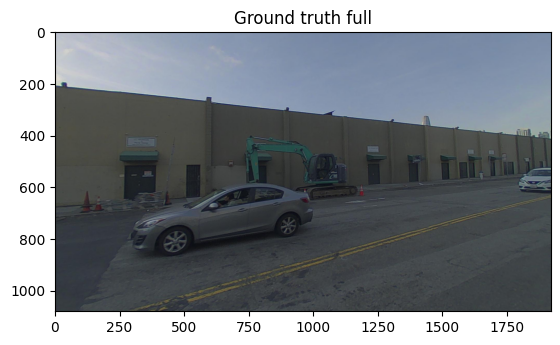

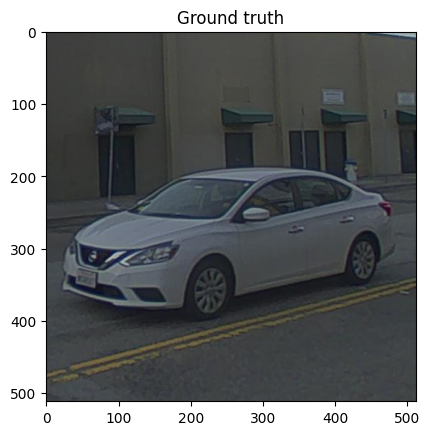

In [110]:
import torch
from nerfstudio.generative.utils import show_img



from pathlib import Path
import pickle

SAVE_MOCK = False

mock_path = Path("tests/mock_data")
full_image_path = mock_path / "full_image_front_left"
full_image_path.mkdir(exist_ok=True, parents=True)

batch_path = mock_path / "batch_front_left"
batch_path.mkdir(exist_ok=True, parents=True)

if SAVE_MOCK:
    with torch.no_grad():
        full_image_path.mkdir(exist_ok=True, parents=True)

        camera, batch = neurad_base_diffusion_pipe.datamanager.next_eval_image(0)

        with open(full_image_path / "camera.pkl", "wb") as f:
            pickle.dump(camera, f)
        with open(full_image_path / "batch.pkl", "wb") as f:
            pickle.dump(batch, f)

        ray_bundle, batch = neurad_base_diffusion_pipe.datamanager.next_eval(0)
        batch_path.mkdir(exist_ok=True, parents=True)

        with open(batch_path / "ray_bundle.pkl", "wb") as f:
            pickle.dump(ray_bundle, f)
        with open(batch_path / "batch.pkl", "wb") as f:
            pickle.dump(batch, f)
        

with open(full_image_path / "camera.pkl", "rb") as f:
    camera_full = pickle.load(f)
with open(full_image_path / "batch.pkl", "rb") as f:
    batch_full = pickle.load(f)
with open(batch_path / "ray_bundle.pkl", "rb") as f:
    ray_bundle = pickle.load(f)
with open(batch_path / "batch.pkl", "rb") as f:
    batch = pickle.load(f)

import matplotlib.pyplot as plt

gt_full = batch_full["image"]
gt = batch["image"]

plt.imshow(gt_full.cpu().numpy())
plt.title("Ground truth full")
plt.show()

plt.imshow(gt.cpu().numpy().squeeze())
plt.title("Ground truth")
plt.show()


In [22]:
from copy import deepcopy
from typing import Tuple
from torch import Tensor
from PIL import Image
import torch
from nerfstudio.cameras.cameras import Cameras
from nerfstudio.pipelines.diffusion_nerf_pipeline import PoseConfig, rotate_around


def shift_cameras(cameras: Cameras, pose_offset: Tensor) -> Tuple[Cameras, Tensor]:
    cameras = deepcopy(cameras)
    device = cameras.device
    aug_translation = pose_offset[..., :3].to(device=device)  # 3
    aug_rotation = pose_offset[..., 3:].to(device=device)  # 3

    c2w = cameras.camera_to_worlds 
    translation = c2w[..., :3] @ aug_translation

    local_rotation = (  # Chain together rotations, X -> Y -> Z
        rotate_around(aug_rotation[2], 2)
        @ rotate_around(aug_rotation[1], 1)
        @ rotate_around(aug_rotation[0], 0)
    ).to(device)
    c2w[:, :3, :3] = local_rotation @ c2w[:, :3, :3]
    c2w[:, :3, 3:4] += translation.reshape(-1, 3, 1)

    cameras.camera_to_worlds = c2w

    with torch.no_grad():
        img_out = pipe.model.get_outputs_for_camera(cameras)

    return cameras, img_out


def prettify_img(img: Tensor, title: str = ""):
    img = img.detach().cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    pil_image = Image.fromarray((img * 255).astype("uint8")) 
    return pil_image
    


In [80]:
camera_full

Cameras(camera_to_worlds=tensor([[[ 5.0968e-01,  5.1461e-02,  8.5882e-01, -1.0295e+00],
         [ 8.5987e-01,  3.4242e-03, -5.1050e-01,  3.5795e+01],
         [-2.9212e-02,  9.9867e-01, -4.2505e-02, -3.0314e-01]]],
       device='cuda:0'), fx=tensor([[929.8429]], device='cuda:0'), fy=tensor([[930.0592]], device='cuda:0'), cx=tensor([[972.1794]], device='cuda:0'), cy=tensor([[508.0057]], device='cuda:0'), width=tensor([[1920]], device='cuda:0'), height=tensor([[1080]], device='cuda:0'), distortion_params=None, camera_type=tensor([[1]], device='cuda:0'), times=tensor([[7.1001]], device='cuda:0'), metadata={'sensor_idxs': tensor([[0]], device='cuda:0', dtype=torch.int32), 'velocities': tensor([[-0.2797, 12.5652,  0.0762]], device='cuda:0'), 'rolling_shutter_offsets': tensor([[-0.0300,  0.0100]], device='cuda:0')})

In [88]:
dataset.cameras[0:1].to(device="cuda")

Cameras(camera_to_worlds=tensor([[[ 5.7221e-01,  5.3557e-02,  8.1836e-01, -1.0537e+00],
         [ 8.1971e-01, -6.4306e-03, -5.7274e-01, -3.7436e+01],
         [-2.5411e-02,  9.9854e-01, -4.7581e-02, -2.5164e-01]]],
       device='cuda:0'), fx=tensor([[929.8429]], device='cuda:0'), fy=tensor([[930.0592]], device='cuda:0'), cx=tensor([[972.1794]], device='cuda:0'), cy=tensor([[508.0057]], device='cuda:0'), width=tensor([[1920]], device='cuda:0'), height=tensor([[1080]], device='cuda:0'), distortion_params=None, camera_type=tensor([[1]], device='cuda:0'), times=tensor([[0.1000]], device='cuda:0'), metadata={'sensor_idxs': tensor([[0]], device='cuda:0', dtype=torch.int32), 'velocities': tensor([[0.2113, 7.8005, 0.0287]], device='cuda:0'), 'rolling_shutter_offsets': tensor([[-0.0300,  0.0100]], device='cuda:0')})

In [103]:
for k, v in vars(camera_full).items():
    if not isinstance(v, torch.Tensor):
        print(k, v)
        continue

    print(k, v.shape, type(v))
    if v.shape == torch.Size([1, 1]):
        vp = v[0, 0]
        print("\t", vp)

print()

for k, v in vars(dataset.cameras[0:1].to(device="cuda")).items():
    if not isinstance(v, torch.Tensor):
        print(k, v)
        continue
    print(k, v.shape, type(v))
    if v.shape == torch.Size([1, 1]):
        vp = v[0, 0]
        print("\t", vp)


_field_custom_dimensions {'camera_to_worlds': 2}
camera_to_worlds torch.Size([1, 3, 4]) <class 'torch.Tensor'>
fx torch.Size([1, 1]) <class 'torch.Tensor'>
	 tensor(929.8429, device='cuda:0')
fy torch.Size([1, 1]) <class 'torch.Tensor'>
	 tensor(930.0592, device='cuda:0')
cx torch.Size([1, 1]) <class 'torch.Tensor'>
	 tensor(972.1794, device='cuda:0')
cy torch.Size([1, 1]) <class 'torch.Tensor'>
	 tensor(508.0057, device='cuda:0')
distortion_params None
height torch.Size([1, 1]) <class 'torch.Tensor'>
	 tensor(1080, device='cuda:0')
width torch.Size([1, 1]) <class 'torch.Tensor'>
	 tensor(1920, device='cuda:0')
camera_type torch.Size([1, 1]) <class 'torch.Tensor'>
	 tensor(1, device='cuda:0')
times torch.Size([1, 1]) <class 'torch.Tensor'>
	 tensor(7.1001, device='cuda:0')
metadata {'sensor_idxs': tensor([[0]], device='cuda:0', dtype=torch.int32), 'velocities': tensor([[-0.2797, 12.5652,  0.0762]], device='cuda:0'), 'rolling_shutter_offsets': tensor([[-0.0300,  0.0100]], device='cuda:0

In [ ]:
import itertools as it
import tqdm

neurad_base_diffusion_pipe.eval()
base_neurad_pipe.eval()

GEN_TRAINED_DIFFUSION = True
if GEN_TRAINED_DIFFUSION:
    imgs_dir = Path("experiments/Images")
    experiment_name = "Neurad_Base_Diffusion"
    task_name = "trained_model"
    img_subdir = imgs_dir / experiment_name / task_name / sequence
    img_subdir.mkdir(parents=True, exist_ok=True)

    dataset = neurad_base_diffusion_pipe.datamanager.eval_dataset
    for img_idx in tqdm.tqdm(range(len(dataset)), desc="Generating images..."):
        camera = dataset.cameras[img_idx:img_idx+1].to(device="cuda")
        img = dataset.get_image_float32(img_idx).to(device="cuda")

        with torch.no_grad():
            img_out_neurad_base_diffusion = neurad_base_diffusion_pipe.model.get_outputs_for_camera(camera)
            img_out_base_neurad = base_neurad_pipe.model.get_outputs_for_camera(camera)

        img_out_gt = prettify_img(img)
        img_out_gt_name = f"{img_idx}_gt.png"
        img_out_gt_path = img_subdir / img_out_gt_name
        img_out_gt.save(img_out_gt_path)

        img_out_neurad_base_diffusion = prettify_img(img_out_neurad_base_diffusion["rgb"])
        img_out_neurad_base_diffusion_name = f"{img_idx}_neurad_base_diffusion.png"
        img_out_neurad_base_diffusion_path = img_subdir / img_out_neurad_base_diffusion_name
        img_out_neurad_base_diffusion.save(img_out_neurad_base_diffusion_path)

        img_out_base_neurad = prettify_img(img_out_base_neurad["rgb"])
        img_out_base_neurad_name = f"{img_idx}_base_neurad.png"
        img_out_base_neurad_path = img_subdir / img_out_base_neurad_name
        img_out_base_neurad.save(img_out_base_neurad_path)


Generating images...: 100%|██████████| 40/40 [01:33<00:00,  2.34s/it]
